Epoch 1, Loss: 0.0685
Epoch 2, Loss: 0.0335
Epoch 3, Loss: 0.0890
Epoch 4, Loss: 0.3645
Epoch 5, Loss: 0.0234
Epoch 6, Loss: 0.0201
Epoch 7, Loss: 0.0073
Epoch 8, Loss: 0.0010
Epoch 9, Loss: 0.0074
Epoch 10, Loss: 0.0146
Model accuracy: 97.3600%
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97    

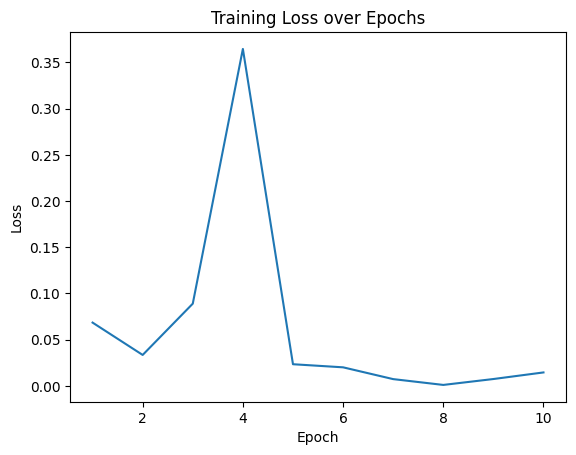


Weights and biases have been saved to .txt files


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()

losses = []
for epoch in range(10):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

training_time = time.time() - start_time

correct = 0
total = 0
y_true = []
y_pred = []
start_inference_time = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

inference_time = time.time() - start_inference_time

accuracy = 100 * correct / total
print(f"Model accuracy: {accuracy:.4f}%")
print(f"Classification report:\n{classification_report(y_true, y_pred)}")
print(f"Training time: {training_time:.2f} s")
print(f"Inference time: {inference_time:.2f} s")

plt.plot(range(1, 11), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

mlp_model = model
weights = mlp_model.state_dict()

for name, param in weights.items():
    if 'weight' in name:
        np.save(f"{name}_weights.txt", param.numpy())
    elif 'bias' in name:
        np.save(f"{name}_biases.txt", param.numpy())

print("\nWeights and biases have been saved to .txt files")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

teacher_model = TeacherNet()
student_model = StudentNet()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(student_model.parameters(), lr=0.001)

print("Training teacher model...")
start_training_time = time.time()
teacher_model.train()
for epoch in range(5):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
training_time = time.time() - start_training_time

print("Distilling knowledge into student model...")
def distillation_loss(student_output, teacher_output, labels, temperature=3.0, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction='batchmean')(nn.functional.log_softmax(student_output/temperature, dim=1),
                                                    nn.functional.softmax(teacher_output/temperature, dim=1))
    hard_loss = criterion(student_output, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

start_training_time = time.time()
for epoch in range(10):
    for images, labels in train_loader:
        optimizer.zero_grad()
        teacher_outputs = teacher_model(images).detach()
        student_outputs = student_model(images)
        loss = distillation_loss(student_outputs, teacher_outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Distillation Loss: {loss.item():.4f}")
training_time = time.time() - start_training_time

start_inference_time = time.time()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = student_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
inference_time = time.time() - start_inference_time

accuracy = 100 * correct / total
print(f"Model accuracy: {accuracy:.4f}%")
print(f"Classification report:\n{classification_report(y_true, y_pred)}")
print(f"Training time: {training_time:.2f} s")
print(f"Inference time: {inference_time:.2f} s")

# Save weights and biases
weights = student_model.state_dict()
for name, param in weights.items():
    np.save(f"{name}_weights.txt", param.numpy())
print("\nWeights and biases have been saved to .txt files")


Training teacher model...
Epoch 1, Loss: 2.3119
Epoch 2, Loss: 2.2868
Epoch 3, Loss: 2.2949
Epoch 4, Loss: 2.3277
Epoch 5, Loss: 2.3172
Distilling knowledge into student model...
Epoch 1, Distillation Loss: 0.1800
Epoch 2, Distillation Loss: 0.1511
Epoch 3, Distillation Loss: 0.2070
Epoch 4, Distillation Loss: 0.1644
Epoch 5, Distillation Loss: 0.1515
Epoch 6, Distillation Loss: 0.1525
Epoch 7, Distillation Loss: 0.1528
Epoch 8, Distillation Loss: 0.1749
Epoch 9, Distillation Loss: 0.1369
Epoch 10, Distillation Loss: 0.1551
Model accuracy: 97.4600%
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98